# Human Activity Recognition – EDA & Discovery of a Hidden Data Issue  
**Goal:** Uncover a subtle but critical issue in the 6-axis accelerometer dataset (leg & arm sensors)

In [31]:
# CELL 1: Import libraries
import pandas as pd
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [32]:
# CELL 2: List all CSV files and display their current column order
files = glob.glob("*.csv")
print(f"Found {len(files)} CSV files in the current directory:\n")
for f in files:
    df_temp = pd.read_csv(f, nrows=1)
    print(f"{f:20} → columns: {list(df_temp.columns)} → shape: {pd.read_csv(f).shape}")

Found 8 CSV files in the current directory:

1_sbj_0.csv          → columns: ['leg_acc_x', 'leg_acc_y', 'leg_acc_z', 'arm_acc_x', 'arm_acc_y', 'arm_acc_z', 'label'] → shape: (69863, 7)
1_sbj_0_2.csv        → columns: ['leg_acc_x', 'leg_acc_y', 'leg_acc_z', 'arm_acc_x', 'arm_acc_y', 'arm_acc_z', 'label'] → shape: (56025, 7)
1_sbj_1.csv          → columns: ['leg_acc_x', 'leg_acc_y', 'leg_acc_z', 'arm_acc_x', 'arm_acc_y', 'arm_acc_z', 'label'] → shape: (69450, 7)
1_sbj_2.csv          → columns: ['leg_acc_x', 'leg_acc_y', 'leg_acc_z', 'arm_acc_x', 'arm_acc_y', 'arm_acc_z', 'label'] → shape: (89100, 7)
2_sbj_0.csv          → columns: ['arm_acc_x', 'arm_acc_y', 'arm_acc_z', 'leg_acc_x', 'leg_acc_y', 'leg_acc_z', 'label'] → shape: (69863, 7)
2_sbj_0_2.csv        → columns: ['arm_acc_x', 'arm_acc_y', 'arm_acc_z', 'leg_acc_x', 'leg_acc_y', 'leg_acc_z', 'label'] → shape: (56025, 7)
2_sbj_1.csv          → columns: ['arm_acc_x', 'arm_acc_y', 'arm_acc_z', 'leg_acc_x', 'leg_acc_y', 'leg_acc_z', 'lab

In [34]:
# CELL 3 - Fix column order for 'subject 2' files (in-memory only – original files unchanged)
import pandas as pd
import os

print("Fixing column order for subject 2 files – in memory only\n")

# Get the correct column order from a subject 1 file
ref_file = "1_sbj_0.csv"
reference_cols = pd.read_csv(ref_file, nrows=0).columns.tolist()
print(f"Reference file (subject 1): {ref_file}")
print(f"Correct column order: {reference_cols}\n")

corrected_dfs = {}   # Dictionary to hold the 8 processed DataFrames
fixed = 0

# Process all 8 files
for f in os.listdir('.'):
    if not f.endswith('.csv'):
        continue
    df = pd.read_csv(f)
    
    # Detect swapped order in subject 2 files (arm columns appear first)
    if f.startswith('2_sbj') and list(df.columns)[:3] == ['arm_acc_x', 'arm_acc_y', 'arm_acc_z']:
        print(f"Swapped order detected → {f} → Fixing")
        df = df[reference_cols]
        fixed += 1
    else:
        print(f"Correct order → {f} → Keeping unchanged")
    
    corrected_dfs[f] = df   # Keep each file separate

print(f"\nSuccessfully fixed column order for {fixed} subject 2 files")
print("→ 8 files stored in variable: corrected_dfs")
print("→ Original files on disk remain untouched → Cell 2 output stays the same")

Fixing column order for subject 2 files – in memory only

Reference file (subject 1): 1_sbj_0.csv
Correct column order: ['leg_acc_x', 'leg_acc_y', 'leg_acc_z', 'arm_acc_x', 'arm_acc_y', 'arm_acc_z', 'label']

Correct order → 1_sbj_0.csv → Keeping unchanged
Correct order → 1_sbj_0_2.csv → Keeping unchanged
Correct order → 1_sbj_1.csv → Keeping unchanged
Correct order → 1_sbj_2.csv → Keeping unchanged
Swapped order detected → 2_sbj_0.csv → Fixing
Swapped order detected → 2_sbj_0_2.csv → Fixing
Swapped order detected → 2_sbj_1.csv → Fixing
Swapped order detected → 2_sbj_2.csv → Fixing

Successfully fixed column order for 4 subject 2 files
→ 8 files stored in variable: corrected_dfs
→ Original files on disk remain untouched → Cell 2 output stays the same


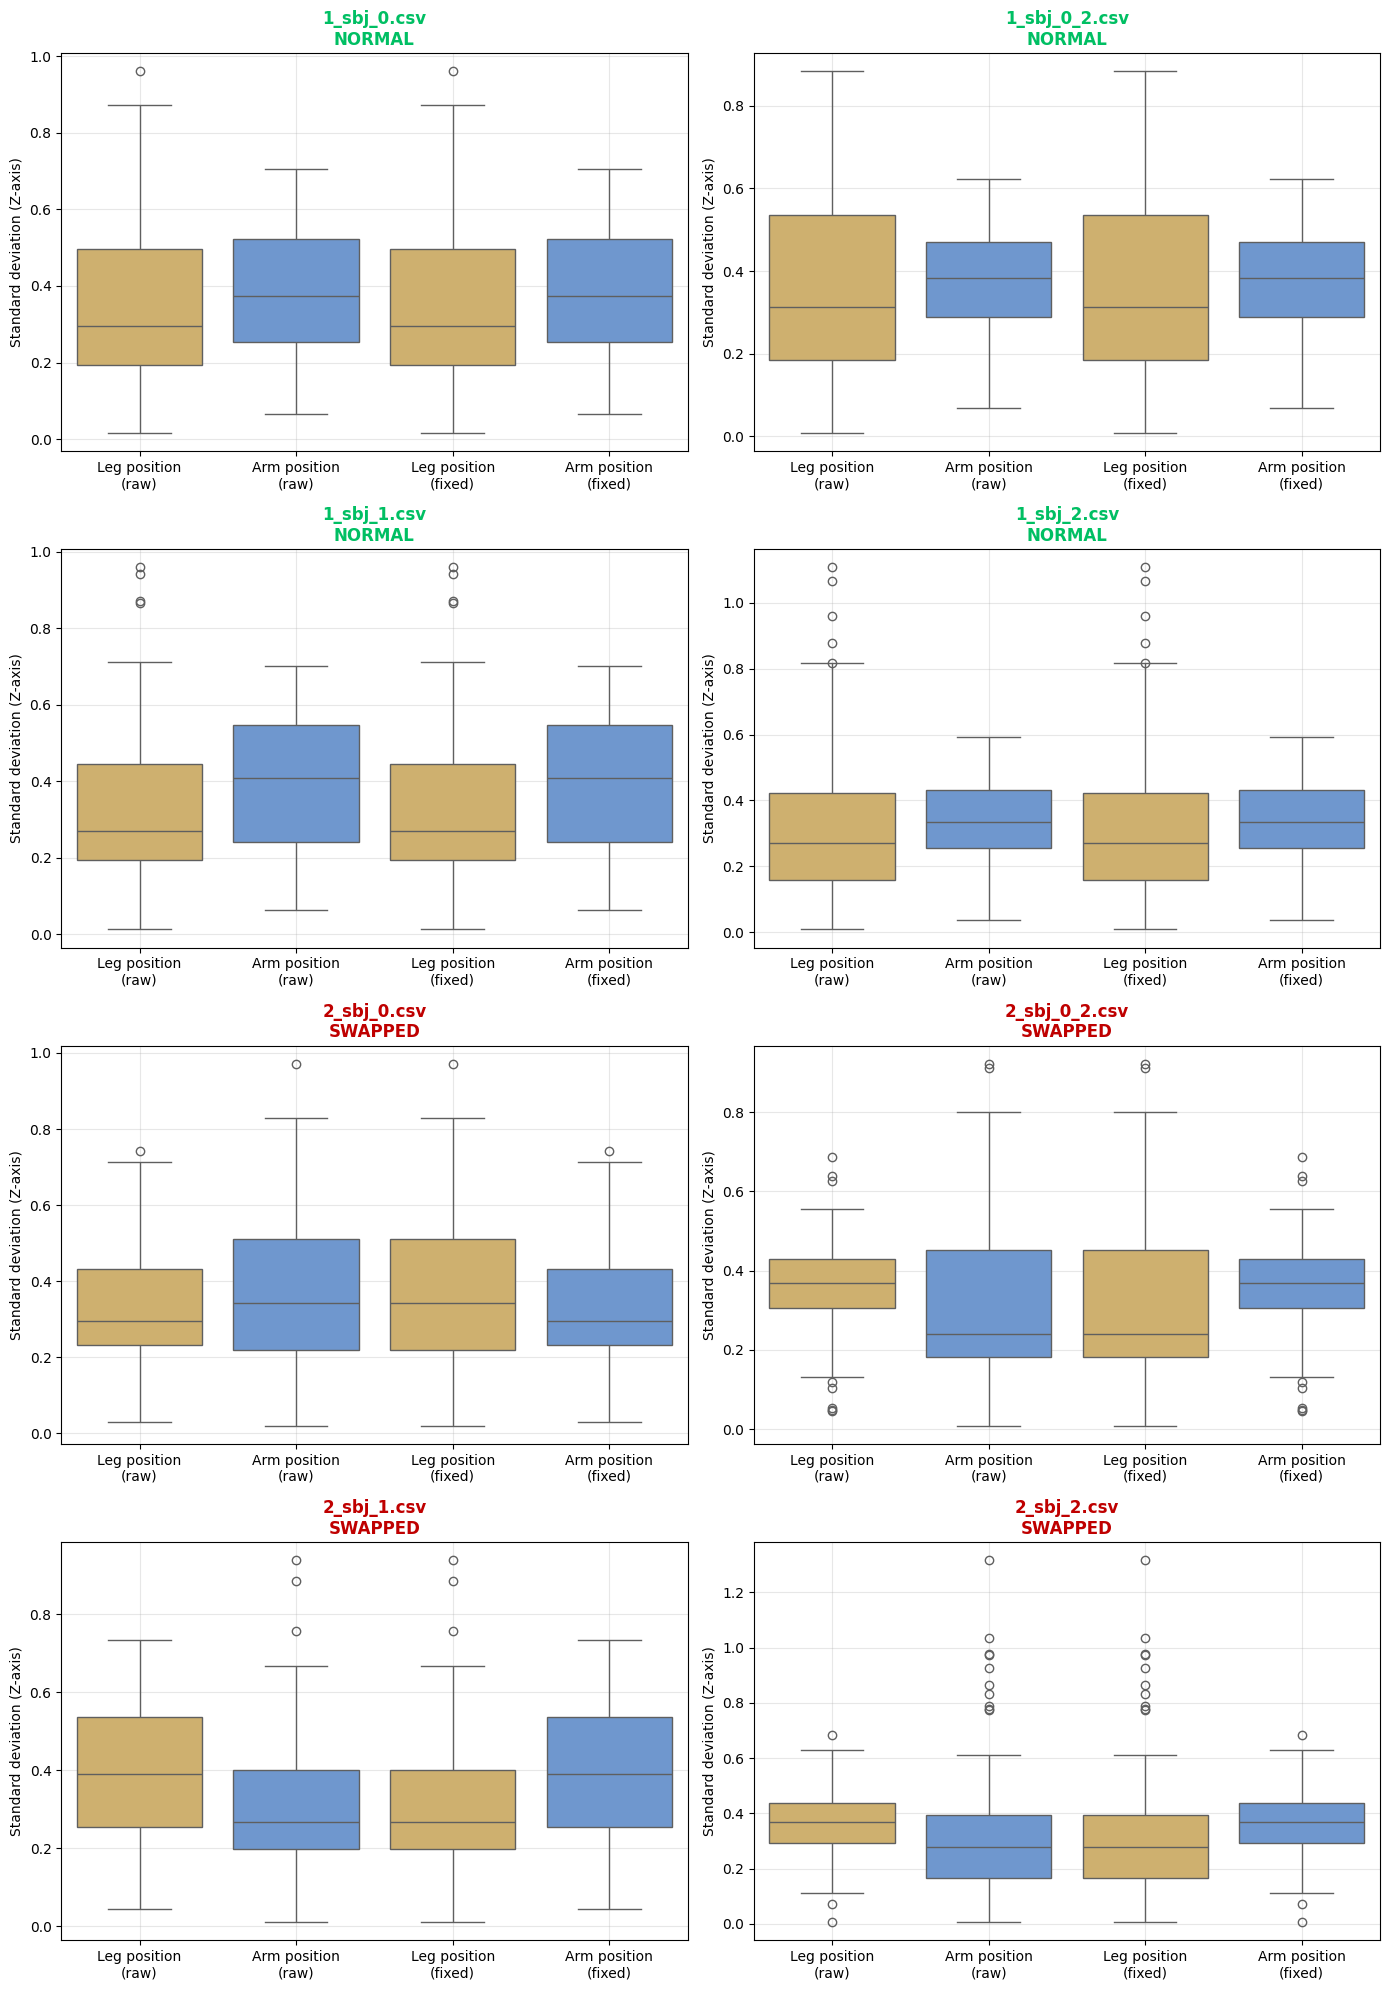

Physical reality: Leg movements have larger amplitude than arm movements → leg sensor std must be higher than arm sensor std.
→ The leg-position sensor must show higher standard deviation than the arm-position sensor.
Due to column swapping in subject 2 files, the raw data shows the opposite pattern (leg position has lower std than arm position) – which is physically incorrect.
After reordering, the correct physical relationship is restored in all files.


In [35]:
# CELL 4: Boxplot comparison of Z-axis standard deviation – raw vs fixed files
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os

# Correct physical column order
reference_cols = ['leg_acc_x', 'leg_acc_y', 'leg_acc_z', 'arm_acc_x', 'arm_acc_y', 'arm_acc_z', 'label']
leg_z_pos = 2   # correct index of leg_acc_z
arm_z_pos = 5   # correct index of arm_acc_z

files = sorted([f for f in os.listdir('.') if f.endswith('.csv')])

fig, axes = plt.subplots(4, 2, figsize=(14, 20))
axes = axes.flatten()

for idx, f in enumerate(files):
    df_raw   = pd.read_csv(f)
    df_clean = corrected_dfs[f]  # from CELL 3
    
    # Compute std over sliding windows (position-based, regardless of column name)
    def get_std(col_idx, df):
        vals = df.iloc[:, col_idx].values
        return [np.std(vals[i:i+1000]) for i in range(0, len(vals), 1000) if len(vals[i:i+1000]) > 50]
    
    # Raw file – values at the physical positions in the original file
    std_leg_raw_pos  = get_std(leg_z_pos, df_raw)   # position that should be leg
    std_arm_raw_pos  = get_std(arm_z_pos, df_raw)   # position that should be arm
    
    # Fixed file – values at the correct positions after reordering
    std_leg_clean = get_std(leg_z_pos, df_clean)
    std_arm_clean = get_std(arm_z_pos, df_clean)
    
    # Plot
    ax = axes[idx]
    data = [std_leg_raw_pos, std_arm_raw_pos, std_leg_clean, std_arm_clean]
    sns.boxplot(data=data, palette=["#deb65f", "#5f95de", "#deb65f", "#5f95de"], ax=ax)
    ax.set_title(f"{f}\n{'SWAPPED' if f.startswith('2_sbj') else 'NORMAL'}", 
                 fontsize=12, fontweight='bold',
                 color='#bf0000' if f.startswith('2_sbj') else '#00bf63')
    ax.set_xticklabels([
        'Leg position\n(raw)',
        'Arm position\n(raw)',
        'Leg position\n(fixed)',
        'Arm position\n(fixed)'
    ], fontsize=10)
    ax.set_ylabel("Standard deviation (Z-axis)")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Physical reality: Leg movements have larger amplitude than arm movements → "
      "leg sensor std must be higher than arm sensor std.")
print("→ The leg-position sensor must show higher standard deviation than the arm-position sensor.")
print("Due to column swapping in subject 2 files, the raw data shows the opposite pattern "
      "(leg position has lower std than arm position) – which is physically incorrect.")
print("After reordering, the correct physical relationship is restored in all files.")